In [1]:
import sys
print(sys.version)

3.10.11 (main, May  4 2023, 18:04:38) [GCC 11.3.0]


In [2]:
!nvidia-smi

Fri Dec 22 09:16:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN Xp                 Off| 00000000:01:00.0 Off |                  N/A |
| 23%   28C    P8                8W / 250W|   6176MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


In [4]:
!pip install torch==2.1.2
!pip install torchvision==0.16.2
!pip install matplotlib==3.8.2

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

if device == "cuda":
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

cuda
NVIDIA TITAN Xp
NVIDIA TITAN X (Pascal)


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

In [8]:
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
model = CNN(10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [12]:
num_epocs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epocs):
    # 学習
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    
    # 検証
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}    " \
    "val_epoch: {}, val_loss: {}, val_acc: {}".format(epoch, running_loss, running_acc, epoch, val_running_loss, val_running_acc))

epoch: 0, loss: 1.3821165732138445, acc: 0.4960612654685974    val_epoch: 0, val_loss: 1.11234585279093, val_acc: 0.5987420082092285
epoch: 1, loss: 0.9082648359615683, acc: 0.678043007850647    val_epoch: 1, val_loss: 0.8245960983415, val_acc: 0.7125598788261414
epoch: 2, loss: 0.734660138038207, acc: 0.7415227293968201    val_epoch: 2, val_loss: 0.747829445634787, val_acc: 0.7388178706169128
epoch: 3, loss: 0.623926621452403, acc: 0.7825695872306824    val_epoch: 3, val_loss: 0.7484656578054825, val_acc: 0.7423123121261597
epoch: 4, loss: 0.5500048830085127, acc: 0.8075016140937805    val_epoch: 4, val_loss: 0.7017594721561042, val_acc: 0.7615814805030823
epoch: 5, loss: 0.4868237378739502, acc: 0.8298744559288025    val_epoch: 5, val_loss: 0.7332915933177875, val_acc: 0.763877809047699
epoch: 6, loss: 0.4318184676608136, acc: 0.8482485413551331    val_epoch: 6, val_loss: 0.7293525823293784, val_acc: 0.7681708931922913
epoch: 7, loss: 0.3828278646297319, acc: 0.8660428524017334    va

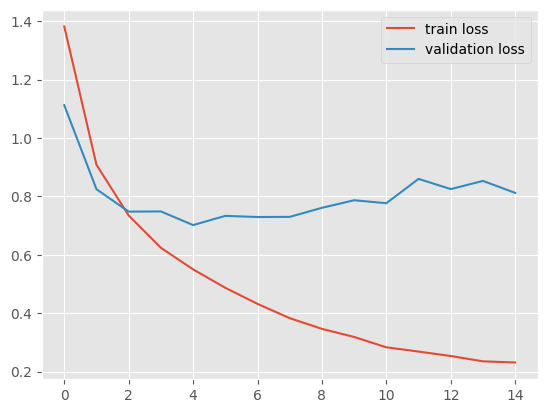

In [13]:
plt.style.use('ggplot')
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [16]:
list(map(lambda x: x.cpu(), accs))

[tensor(0.4961),
 tensor(0.6780),
 tensor(0.7415),
 tensor(0.7826),
 tensor(0.8075),
 tensor(0.8299),
 tensor(0.8482),
 tensor(0.8660),
 tensor(0.8791),
 tensor(0.8871),
 tensor(0.8997),
 tensor(0.9045),
 tensor(0.9095),
 tensor(0.9169),
 tensor(0.9184)]

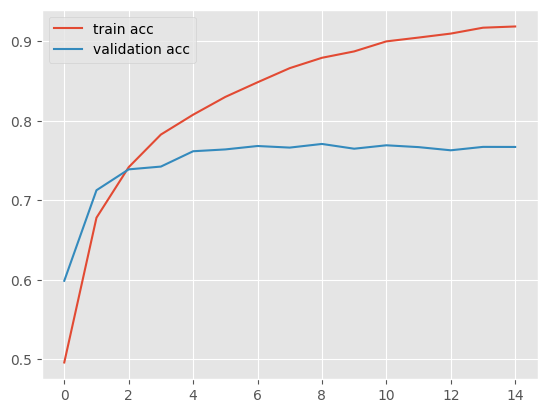

In [17]:
plt.style.use('ggplot')
plt.plot(list(map(lambda x: x.cpu(), accs)) if device == "cuda" else accs, label='train acc')
plt.plot(list(map(lambda x: x.cpu(), val_accs)) if device == "cuda" else val_accs, label='validation acc')
plt.legend()